In [1]:
'''
Author - Hariharasudhan A S (2K17/SE/039)
Date - Sept 4, 2019
Course - ECE353
'''
import cv2
import numpy as np
from matplotlib import pyplot as plt
from skimage.exposure import rescale_intensity
from math import cos, sin, pi

## Utils

In [2]:
def display_old_new(img, dst, descp='Default Descp'):
    '''
    Display two images side-by-side for comparision
    
    Params:
    @img - numpy array - 1 channel, Image 1
    @dst - numpy array - 1 channel, Image 2
    @descp - str, Description of Image 2
    '''
    plt.subplot(121),plt.imshow(img, cmap='gray'),plt.title('Original')
    plt.xticks([]), plt.yticks([])
    plt.subplot(122),plt.imshow(dst, cmap='gray'),plt.title(descp)
    plt.xticks([]), plt.yticks([])
    plt.show()

# Using OpenCV

## Image convolution

CPU times: user 276 µs, sys: 52 µs, total: 328 µs
Wall time: 331 µs


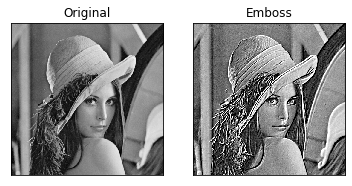

In [3]:
FILE_LOCATION = './lena_gray.png'

img = cv2.imread(FILE_LOCATION, 0)

kernel = np.array([[-2,-1,0],
                   [-1,1,1],
                   [0,1,2]])

%time dst = cv2.filter2D(img,-1,kernel)        
    
display_old_new(img, dst, 'Emboss')

## Image Scaling

CPU times: user 4.22 ms, sys: 0 ns, total: 4.22 ms
Wall time: 2.2 ms


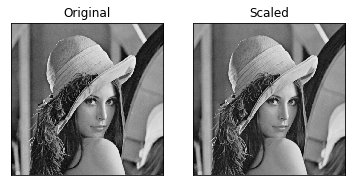

In [4]:
%time res = cv2.resize(img,None,fx=2, fy=2, interpolation = cv2.INTER_CUBIC)

display_old_new(img, res, 'Scaled')

## Image Translation

CPU times: user 1.89 ms, sys: 281 µs, total: 2.17 ms
Wall time: 817 µs


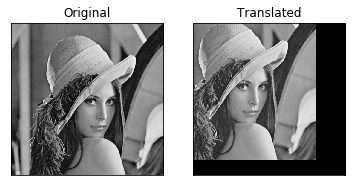

In [5]:
rows,cols = img.shape

# M is of the form [[1,0,tx],[0,1,ty]]

M = np.float32([[1,0,100],[0,1,50]])
%time dst = cv2.warpAffine(img,M,(cols,rows), flags=cv2.WARP_INVERSE_MAP)

display_old_new(img, dst, 'Translated')

## Image Rotation

CPU times: user 1.33 ms, sys: 184 µs, total: 1.51 ms
Wall time: 603 µs


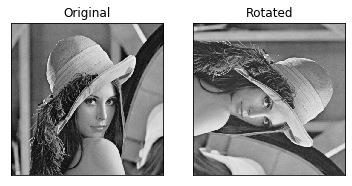

In [6]:
rows,cols = img.shape

M = cv2.getRotationMatrix2D((cols/2,rows/2),90,1)
%time dst = cv2.warpAffine(img,M,(cols,rows), flags=cv2.WARP_INVERSE_MAP)

display_old_new(img, dst, 'Rotated')

# In native python

## Custom implementations

In [7]:
def custom_warpaffine(image, matrix, shape):
    '''
    clone of cv2.warpAffine(.., flags=cv2.WARP_INVERSE_MAP, ..)
    Follows nearest-neighbour interpolation
    
    @Params:
    
    image - numpy array - 1 channel, source image
    matrix - numpy array of size (2, 3), affine transform matrix
    shape - int tuple, shape of source image
    
    @returns:
    
    output - numpy array - 1 channel, image after affine transform
    '''
    output = np.zeros_like(image, dtype=np.float32)
    
    for x in range(shape[0]):
        for y in range(shape[1]):
            transformed_x = int(matrix[0,0]*x + matrix[0,1]*y + matrix[0,2])
            transformed_y = int(matrix[1,0]*x + matrix[1,1]*y + matrix[1,2])
            if transformed_x >=shape[0] or transformed_y >=shape[1]:
                pass
            else:
                output[y, x] = image[transformed_y, transformed_x]
    
    return output

In [8]:
def custom_convolve2D(image, kernel):
    '''
    2D convolution
    
    @params:
    image - numpy array - 1 channel, source image
    kernel - numpy array, kernel to be convoluted
    
    @returns:
    output - numpy array - 1 channel, convoluted image
    '''
    (iH, iW) = image.shape[:2]
    (kH, kW) = kernel.shape[:2]
    pad = (kW - 1) // 2
    image = cv2.copyMakeBorder(image, pad, pad, pad, pad,
                               cv2.BORDER_REPLICATE)
    
    output = np.zeros((iH, iW), dtype="float32")
    
    for y in np.arange(pad, iH + pad):
        for x in np.arange(pad, iW + pad):

            roi = image[y - pad:y + pad + 1, x - pad:x + pad + 1]

            k = (roi * kernel).sum()

            output[y - pad, x - pad] = k
    
    output = rescale_intensity(output, in_range=(0, 255))
    output = (output * 255).astype("uint8")
    
    return output

In [9]:
def custom_rotatematrix(center, angle, scale=1):
    '''
    clone of cv2.getRotationMatrix2D
    
    @Params:
    center - tuple, center of rotation
    angle - double, angle in degrees
    scale - double, scaling factor (optional)
    
    @returns:
    out_mat - numpy array - shape(2,3), rotation matrix
    '''
    out_mat = np.zeros((2,3), dtype=np.float32)
    
    alpha = scale * cos(angle*pi/180)
    beta = scale * sin(angle*pi/180)
    
    out_mat[0,0] = alpha
    out_mat[0,1] = beta
    out_mat[0,2] = (1-alpha)*center[0]-beta*center[1]
    out_mat[1,0] = -beta
    out_mat[1,1] = alpha
    out_mat[1,2] = beta*center[0]+(1-alpha)*center[1]
    
    return out_mat

## Image convolution

CPU times: user 1.67 s, sys: 0 ns, total: 1.67 s
Wall time: 1.67 s


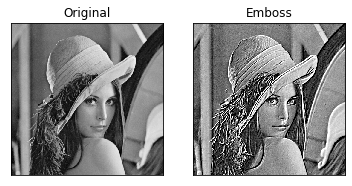

In [10]:
FILE_LOCATION = './lena_gray.png'

img = cv2.imread(FILE_LOCATION, 0)

kernel = np.array([[-2,-1,0],
                   [-1,1,1],
                   [0,1,2]])


%time dst = custom_convolve2D(img,kernel)        

display_old_new(img, dst, 'Emboss')

## Image Translation

In [11]:
rows,cols = img.shape

# M is of the form [[1,0,tx],[0,1,ty]]

M = np.float32([[1,0,100],[0,1,50]])
%time dst = custom_warpaffine(img,M,(cols,rows))

CPU times: user 2.74 s, sys: 0 ns, total: 2.74 s
Wall time: 2.75 s


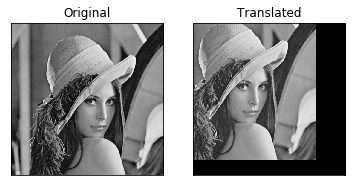

In [12]:
display_old_new(img, dst, 'Translated')

## Image Rotation

CPU times: user 2.72 s, sys: 0 ns, total: 2.72 s
Wall time: 2.72 s


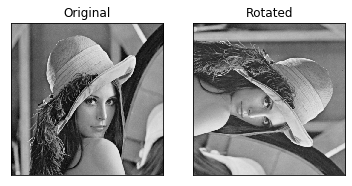

In [13]:
rows,cols = img.shape

M = custom_rotatematrix((cols/2,rows/2),90,1)
%time dst = custom_warpaffine(img,M,(cols,rows))

display_old_new(img, dst, 'Rotated')